In [1]:
import pandas as pd
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv("/Users/withmocha/Desktop/DATA/BOAZ/미니 프로젝트 1/data/main data/WELFake_Dataset.csv")
data.drop(data.columns[0], axis=1, inplace=True)
data['title'] = data['title'] + data['text']

In [3]:
X = pd.DataFrame(data=data['title'])
Y = pd.DataFrame(data=data['label'])

In [4]:
texts = X['title'].tolist()
labels = Y['label'].tolist()
texts = [str(text) if pd.notna(text) else "" for text in texts]

In [5]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, shuffle=True)

In [6]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [7]:
def encode_data(texts, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

In [8]:
train_input_ids, train_attention_masks = encode_data(train_texts, tokenizer)
val_input_ids, val_attention_masks = encode_data(val_texts, tokenizer)

In [9]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [10]:
def create_transformer_input(input_ids, attention_masks, batch_size=32):
    def gen():
        for i in range(0, len(input_ids), batch_size):
            yield input_ids[i:i + batch_size], attention_masks[i:i + batch_size]

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(tf.TensorSpec(shape=(None, input_ids.shape[1]), dtype=tf.int32),
                          tf.TensorSpec(shape=(None, attention_masks.shape[1]), dtype=tf.int32))
    )

    features = []
    for batch_input_ids, batch_attention_masks in dataset:
        outputs = roberta_model(batch_input_ids, attention_mask=batch_attention_masks)
        features.append(outputs.last_hidden_state)

    return tf.concat(features, axis=0)

In [11]:
train_features = create_transformer_input(train_input_ids, train_attention_masks)
val_features = create_transformer_input(val_input_ids, val_attention_masks)

2024-08-25 20:24:07.541086: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-25 20:39:10.130948: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
input_layer = tf.keras.layers.Input(shape=(train_features.shape[1], train_features.shape[2]), dtype=tf.float32)
bilstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(input_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(bilstm_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_layer)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 768)]        0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                205056    
 onal)                                                           
                                                                 
 dropout_41 (Dropout)        (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 205121 (801.25 KB)
Trainable params: 205121 (801.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
import numpy as np

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)


EPOCHS = 20
BATCH_SIZE = 64

history = model.fit(
    train_features,
    train_labels,
    validation_data=(val_features, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/20
902/902 [==============================] - 110s 120ms/step - loss: 0.4407 - accuracy: 0.8009 - val_loss: 0.1934 - val_accuracy: 0.9364
Epoch 2/20
902/902 [==============================] - 90s 100ms/step - loss: 0.1468 - accuracy: 0.9538 - val_loss: 0.1074 - val_accuracy: 0.9653
Epoch 3/20
902/902 [==============================] - 83s 92ms/step - loss: 0.0974 - accuracy: 0.9694 - val_loss: 0.0851 - val_accuracy: 0.9715
Epoch 4/20
902/902 [==============================] - 115s 128ms/step - loss: 0.0781 - accuracy: 0.9758 - val_loss: 0.0718 - val_accuracy: 0.9763
Epoch 5/20
902/902 [==============================] - 93s 103ms/step - loss: 0.0663 - accuracy: 0.9791 - val_loss: 0.0637 - val_accuracy: 0.9792
Epoch 6/20
902/902 [==============================] - 113s 126ms/step - loss: 0.0570 - accuracy: 0.9825 - val_loss: 0.0579 - val_accuracy: 0.9808
Epoch 7/20
902/902 [==============================] - 90s 100ms/step - loss: 0.0512 - accuracy: 0.9845 - val_loss: 0.0517 - val_

451/451 [==============================] - 8s 15ms/step


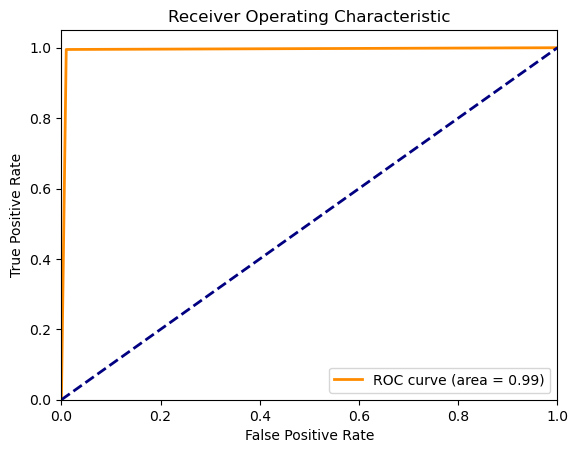

In [24]:
val_pred = model.predict(val_features)
val_pred = (val_pred > 0.5).astype(int)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score

fpr, tpr, _ = roc_curve(val_labels, val_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

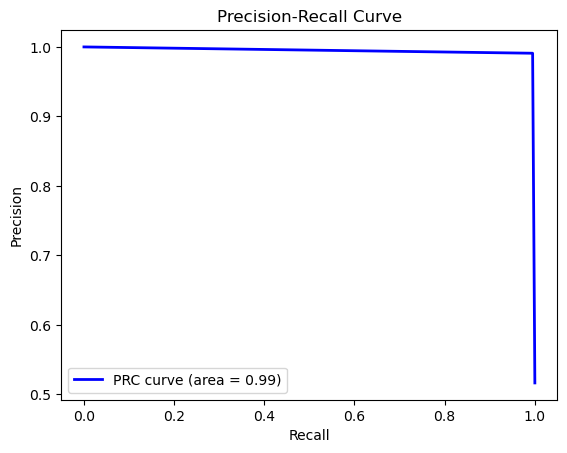

In [25]:
precision, recall, _ = precision_recall_curve(val_labels, val_pred)
prc_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PRC curve (area = %0.2f)' % prc_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

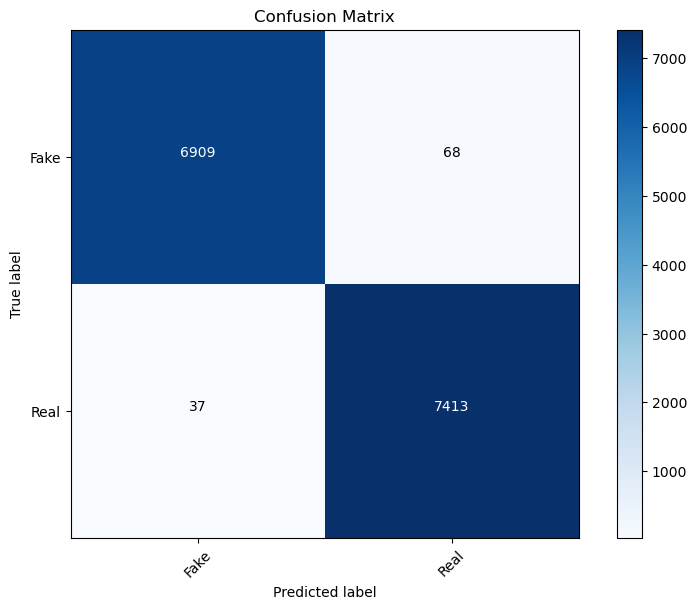

In [26]:
import itertools

conf_matrix = confusion_matrix(val_labels, val_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake', 'Real'], rotation=45)
plt.yticks(tick_marks, ['Fake', 'Real'])

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [27]:
accuracy = accuracy_score(val_labels, val_pred)
print('Accuracy Score:', accuracy)

Accuracy Score: 0.992721979621543


In [28]:
model.save("BiLSTM model.keras")